#### 라이브러리 호출

In [1]:
import logging  # to further silence deprecation warnings
import warnings
from warnings import filterwarnings

# Standard library
import os

# Data handling
import yaml
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning & clustering
from umap import validation

# Custom modules
from denseclus import DenseClus

# Suppress the specific FutureWarning from sklearn
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=".*force_all_finite.*"
)

logging.captureWarnings(True)

In [2]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc={"figure.figsize": (10, 8)})

#### 데이터 호출

In [3]:
# 저장된 yaml 파일 불러오기
YAML_PATH = './yaml/hp_config_20250624_025226.yaml'

with open(YAML_PATH) as file:
    config = yaml.full_load(file)

display(config)

{'setting': {'seed': 42,
  'n_samples': None,
  'dropna': True,
  'method': 'intersection_union_mapper',
  'max_clusters': 10},
 'n_clusters': 3,
 'umap_params': {'categorical': {'n_neighbors': 30, 'min_dist': 0.0},
  'numerical': {'n_neighbors': 40, 'min_dist': 0.2},
  'combined': {'n_neighbors': 5, 'min_dist': 0.2}},
 'hdbscan_params': {'min_samples': 50,
  'min_cluster_size': 1000,
  'gen_min_span_tree': True}}

In [4]:
SEED = config["setting"]["seed"]
np.random.seed(SEED)  # set the random seed as best we can

data_path = './data/flat-training.csv'

df = pd.read_csv(data_path)

# 결측치가 하나라도 있는 열을 제거
if config["setting"]["dropna"]:
    df = df.dropna(axis=1)

# random sampling 진행
if config["setting"]["n_samples"] is not None:
    df = df.sample(n=config["setting"]["n_samples"], random_state=SEED)

df.head(5)

,dog,cat,deer,panda,koala,otter,hedgehog,squirrel,dolphin,penguin,...,blanket,button,whistle,marble,wagon,storybook,candle,clover,bubble,cookie
0,10,A5DB,4.46,-2,T2,B9DE,51.8,0,1,20,...,A8,2,2,0,-0.76,-54,B2,0.38,0,C13
1,10,A5DB,4.42,0,T3,027A,72.2,1,1,20,...,A7,16,0,0,-0.76,-48,B0,0.16,0,C15
2,43,027A,3.11,-1,T0,B9DE,44.2,1,1,20,...,A4,-25,10,0,-0.88,-39,B0,0.13,0,C1
3,28,63D1,3.37,-1,T1,027A,41.0,0,1,20,...,A3,21,9,0,-0.85,-58,B1,0.29,1,C5
4,82,C09E,3.07,-6,T0,B9DE,46.4,1,1,20,...,A7,-4,13,0,-0.85,70,B2,0.75,1,C13


In [5]:
df.dtypes

dog            int64
cat           object
deer         float64
panda          int64
koala         object
              ...   
storybook      int64
candle        object
clover       float64
bubble         int64
cookie        object
Length: 76, dtype: object

#### 모델 학습

In [6]:
# 하이퍼파라미터 호출
umap_params = config["umap_params"]

hdbscan_params = config["hdbscan_params"]

clf = DenseClus(
    random_state=SEED,
    hdbscan_params=hdbscan_params,
    umap_params=umap_params,
    umap_combine_method= config["setting"]["method"]
)

clf.fit(df)

Max of 90 is greater than threshold 25
Hashing categorical features


In [20]:
embedding = clf.mapper_.embedding_
labels = clf.evaluate()
clustered = labels >= 0

cnts = pd.DataFrame(labels)[0].value_counts()
cnts = cnts.reset_index()
cnts.columns = ["cluster", "count"]
print(cnts.sort_values(["cluster"], ignore_index=True))

Coverage 0.95918
Calinski-Harabasz Score: 5454.21561744076
   cluster  count
0       -1   4082
1        0  90049
2        1   1047
3        2   4822


In [21]:
print(np.unique(labels))

embedding.shape

[-1  0  1  2]


(100000, 5)

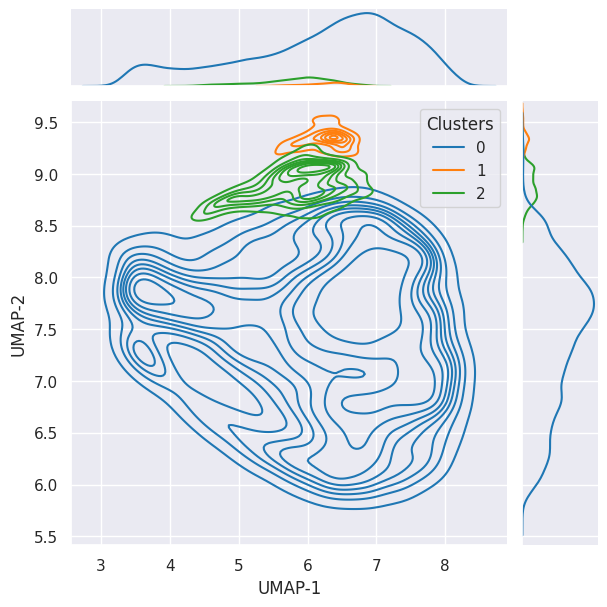

In [11]:
g = sns.jointplot(
    x=embedding[clustered, 0], 
    y=embedding[clustered, -1], 
    hue=labels[clustered], 
    kind="kde", palette='tab10' )

g.set_axis_labels("UMAP-1", "UMAP-2")

legend = g.ax_joint.get_legend()
if legend:
    legend.set_title("Clusters")

plt.show()

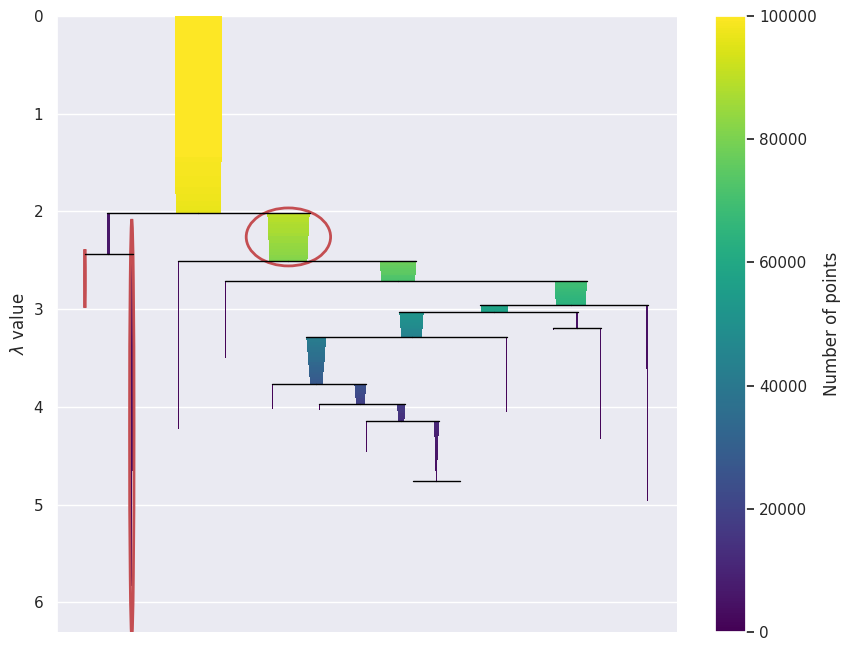

In [12]:
clf.hdbscan_.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=sns.color_palette("deep", np.unique(clustered).shape[0]),
)

plt.show()

In [13]:
coverage = np.sum(clustered) / embedding.shape[0]

print(f"Coverage {coverage}")
print(f"DBCV score {clf.hdbscan_.relative_validity_}")

Coverage 0.95918
DBCV score 0.6685250102154349


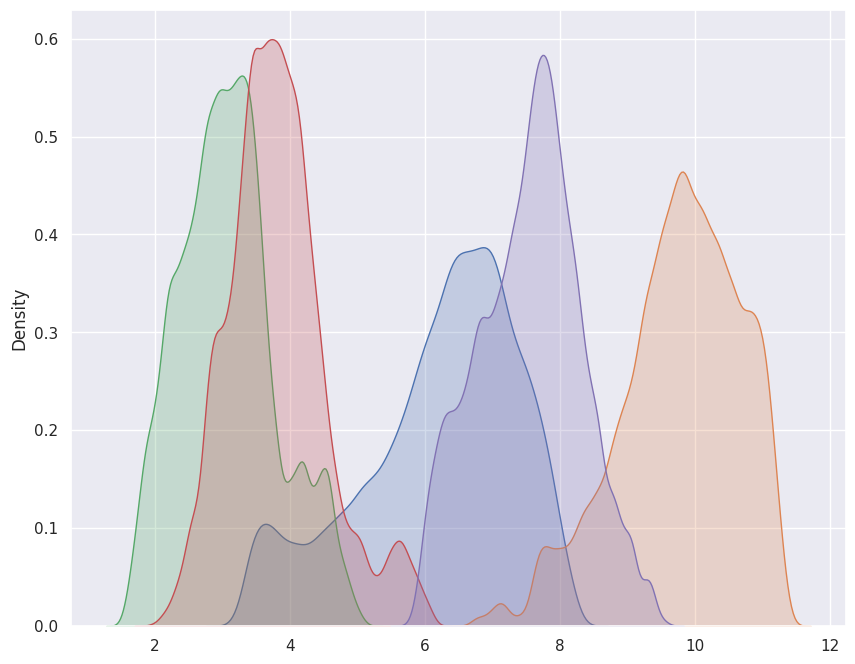

In [14]:
for i in range(len(clf.mapper_.embedding_[0])):
    sns.kdeplot(clf.mapper_.embedding_[:, i], fill=True)

plt.show()

#### UMAP 신뢰도 검사 (오래 걸리니까 하지 마삼)

In [ ]:
K = 50

# supress numba deprecation warnings from UMAP
filterwarnings("ignore")

numerical_trustworthiness = validation.trustworthiness_vector(
    source=clf.numerical_umap_._raw_data, embedding=clf.numerical_umap_.embedding_, max_k=K
)

categorical_trustworthiness = validation.trustworthiness_vector(
    source=clf.categorical_umap_._raw_data, embedding=clf.categorical_umap_.embedding_, max_k=K
)

filterwarnings("default")


plt.plot(numerical_trustworthiness)
plt.plot(categorical_trustworthiness)
plt.ylabel("Trustworthiness score")
plt.xlabel("Value of K")
plt.title(f"Trustworthiness at {K}")

plt.legend(["numerical T", "categorical T"], loc="upper right")

plt.show()

#### 클러스터링 결과 저장

In [ ]:
SAVE_PATH = './results'
os.makedirs(SAVE_PATH, exist_ok=True)

SAVE_NAME = "_".join(os.path.basename(YAML_PATH).split(".")[0].split("_")[2:])
print(SAVE_NAME)

In [ ]:


df['segment'] = clf.evaluate()

# CSV로 저장
df.to_csv(os.path.join(SAVE_PATH, "clustered_data.csv"), index=False)